# Imports

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data

In [6]:
train = pd.read_csv(r"D:\\Disaster_Tweets\train.csv")
test = pd.read_csv(r"D:\\Disaster_Tweets\test.csv")

- The train dataset is 5 columns by 7613 rows. The column headers are
    - Id = a unique identifier for the tweet
    - text = message contents
    - location = area of tweeter 
    - keyword = a particuler standout word
    - target = wether tweet is about a disaster ether 0 or 1

- The test dataset is 4 columns by 3263 rows 
    - Same columns minus target

- Challenge 
    - Build a binary text classifier that seperates disaster tweets from non disaster tweets

# Data EDA

In [7]:
# Check for missing values
print("\nMissing Values:")
print(train.isnull().sum())


Missing Values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [8]:
# Training data overview 
print("\nSummary Statistics:")
print(train.describe())


Summary Statistics:
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


In [9]:
# Drop unecessary ID column 
train_cleaned = train.drop(columns=['id'])
train_cleaned = train_cleaned.dropna(subset=['keyword'])

- Keywords can help us classify tweets, the missing values make up only 0.8% of the training data. 
    - Drop rows without keyword (61)
- There is one column that is not needed 
    - ID

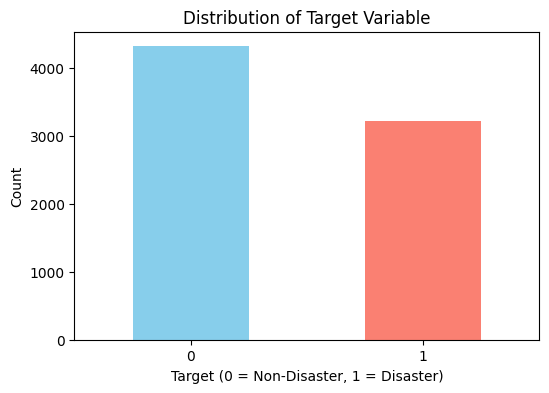

In [10]:
# Check class balance 
plt.figure(figsize=(6, 4))
train_cleaned['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Distribution of Target Variable")
plt.xlabel("Target (0 = Non-Disaster, 1 = Disaster)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

- Class imbalance is not severe enough to cause issue in my opinion so I will not be adjusting for it

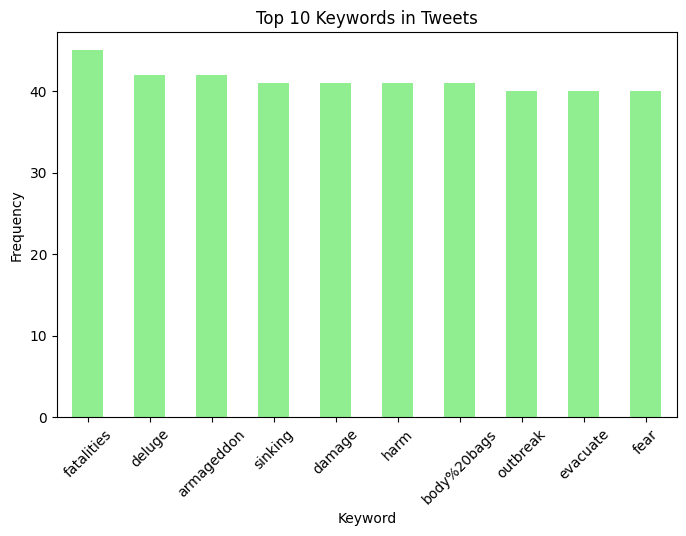

In [11]:
# Plot the top 10 most frequent keywords
keyword_counts = train_cleaned['keyword'].value_counts().head(10)

plt.figure(figsize=(8, 5))
keyword_counts.plot(kind='bar', color='lightgreen')
plt.title("Top 10 Keywords in Tweets")
plt.xlabel("Keyword")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


- Basic plan is to utilize keywords to sort tweets. Preprocess the data via tokens, convert tokens into numerical representations and to build the model
    - model will utilize RNN, LSTM or GRU
    - 3 models will be built and compared via F1-score and accuracy 
- Split training data into training and validation so model can be tested on unseen data 

# Model Architecture

Preprocessing
-	Convert the raw text into numerical form that a neural network can process
-	Utilize pre-trained GloVe embeddings for conversion
-   GloVe is great because it is a pre-trained word embedding technique that maps each word to a dense vector. These vectors capture semantic and syntactic relationships between words to represent underlying messages if they exist. 

LSTM Model Overview
-   Embedding Layer:
    - Transforms the input words (now integers from tokenization) into dense vector representations
    - input_dim=MAX_NUM_WORDS => to limit vocab size
    - output_dim=EMBEDDING_DIM => maps each word to a dense vector of size 100
    - weights=[embedding_matrix] => pretrained word vectors from GloVe
    - input_length=MAX_SEQUENCE_LENGTH => fixes input length
    - trainable=True => The embeddings are tuned during training 
-   Bidirectional LSTM Layers:
    - Processes sequential data forwards and backwards to capture context 
- Dropout Layers
    - Prevent overfitting 
- Dense Output Layer
    - Generates final prediction of model 
    - Outputs probability between 0 and 1 and that probability is rounded based on the threshold 

# Data Preperation

In [ ]:
MAX_NUM_WORDS = 10000  # Maximum vocabulary size
EMBEDDING_DIM = 100  # Dimensionality of the GloVe embeddings
MAX_SEQUENCE_LENGTH = 100  # Maximum sequence length

# Reinitialize tokenizer with MAX_NUM_WORDS to limit the vocabulary
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<UNK>")
tokenizer.fit_on_texts(train_cleaned['text'])

# Convert texts to sequences 
train_sequences = tokenizer.texts_to_sequences(train_cleaned['text'])

# Pad sequences for uniform length
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Check the new shape
print("Shape of padded training data after limiting vocabulary:", train_padded.shape)

Shape of padded training data after limiting vocabulary: (7552, 100)


In [ ]:
# Load GloVe embeddings
GLOVE_PATH = "D:\\Disaster_Tweets\\glove.6B.100d.txt"  
embedding_index = {}

with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding_vector = np.array(values[1:], dtype='float32')
        embedding_index[word] = embedding_vector

print("Number of word vectors in GloVe:", len(embedding_index))

# Rebuild the embedding matrix
word_index = tokenizer.word_index  
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

for word, i in word_index.items():
    if i < MAX_NUM_WORDS:  
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Rebuilt Embedding Matrix Shape:", embedding_matrix.shape)

Number of word vectors in GloVe: 400000
Rebuilt Embedding Matrix Shape: (10000, 100)


In [14]:
# Create Validation Set
X_train, X_val, y_train, y_val = train_test_split(
    train_padded, train_cleaned['target'], test_size=0.2, random_state=42
)
y_train = np.array(y_train)
y_val = np.array(y_val)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (6041, 100)
y_train shape: (6041,)


# Model Building

In [15]:
# LSTM Model
def enhanced_model(lstm_units=[128, 64], dropout_rate=0.3, learning_rate=1e-3):
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_WORDS,
                        output_dim=EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=True))
    for i, units in enumerate(lstm_units):
        return_sequences = i < len(lstm_units) - 1
        model.add(Bidirectional(LSTM(units, return_sequences=return_sequences)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [16]:
# Hyperparameter tuning grid 
param_space = {
    'lstm_units': [[128], [128, 64], [64, 64, 32]],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'epochs': [10]
}

In [ ]:
# Random search setup 
num_iterations = 10
results = []

for i in range(num_iterations):
    # Random Search
    params = {
        'lstm_units': random.choice(param_space['lstm_units']),
        'dropout_rate': random.choice(param_space['dropout_rate']),
        'learning_rate': random.choice(param_space['learning_rate']),
        'batch_size': random.choice(param_space['batch_size']),
        'epochs': random.choice(param_space['epochs'])
    }
    
    print(f"\nIteration {i + 1}/{num_iterations}: Testing with {params}")
    
    # Build and train the model
    model = enhanced_model(
        lstm_units=params['lstm_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=1
    )
    
    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Store results
    results.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history  # Include history here
    })

# Find the best configuration
best_result = max(results, key=lambda x: x['val_accuracy'])
print(f"\nBest Configuration: {best_result['params']}")
print(f"Best Validation Accuracy: {best_result['val_accuracy']:.4f}")



Iteration 1/10: Testing with {'lstm_units': [128], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10}
Epoch 1/10


c:\Users\blake\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7222 - loss: 0.5612 - val_accuracy: 0.8134 - val_loss: 0.4297
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8271 - loss: 0.4058 - val_accuracy: 0.8180 - val_loss: 0.4096
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8518 - loss: 0.3566 - val_accuracy: 0.8193 - val_loss: 0.4111
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8755 - loss: 0.3143 - val_accuracy: 0.8154 - val_loss: 0.4520
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8969 - loss: 0.2686 - val_accuracy: 0.8147 - val_loss: 0.4565
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9167 - loss: 0.2172 - val_accuracy: 0.8041 - val_loss: 0.5175
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9365 - loss: 0.1737 - val_accuracy: 0.8041 - val_loss: 0.5357
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9500 - loss: 0.1415 - val_accuracy: 0.7942 - val_loss: 0.

In [ ]:
# Rebuild and train the model with the best configuration
final_params = best_result['params']

print(f"Training final model with best configuration: {final_params}")

# Build final model
model = enhanced_model(
    lstm_units=final_params['lstm_units'],
    dropout_rate=final_params['dropout_rate'],
    learning_rate=final_params['learning_rate']
)

# Train the best model 
final_history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=final_params['epochs'],
    batch_size=final_params['batch_size'],
    verbose=1
)

# Evaluate final model 
final_val_loss, final_val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}, Final Validation Loss: {final_val_loss:.4f}")


Training final model with best configuration: {'lstm_units': [64, 64, 32], 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10}
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.6086 - loss: 0.6657 - val_accuracy: 0.7776 - val_loss: 0.5408
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.7553 - loss: 0.5312 - val_accuracy: 0.7975 - val_loss: 0.4667
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8005 - loss: 0.4711 - val_accuracy: 0.8094 - val_loss: 0.4456
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8138 - loss: 0.4399 - val_accuracy: 0.8206 - val_loss: 0.4316
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8197 - loss: 0.4346 - val_accuracy: 0.8187 - val_loss: 0.4250
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8186 - loss: 0.4235 - val_accuracy: 0.8193 - val_loss: 0.4228
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8259 - loss: 0.4203

# Results 

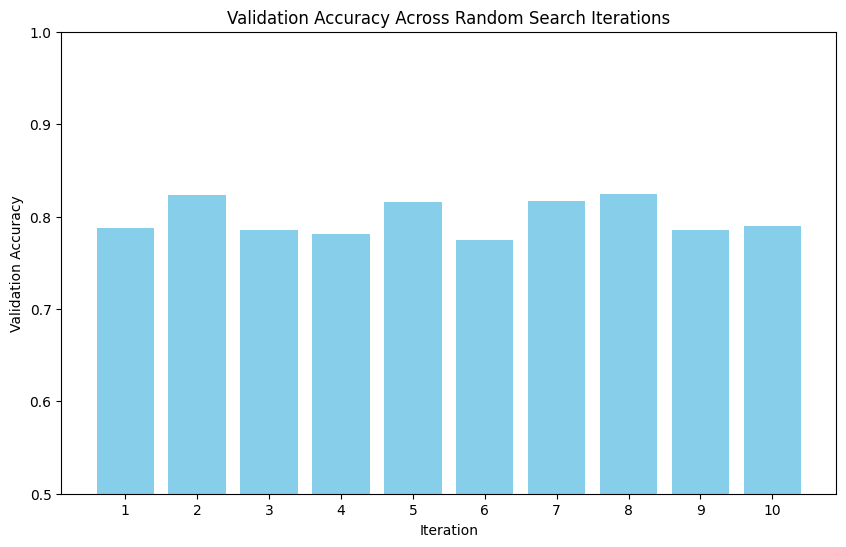

In [ ]:
# Get results from random search
iterations = list(range(1, len(results) + 1))
val_accuracies = [res['val_accuracy'] for res in results]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(iterations, val_accuracies, color='skyblue')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Across Random Search Iterations')
plt.xticks(iterations)
plt.ylim(0.5, 1.0)  
plt.show()


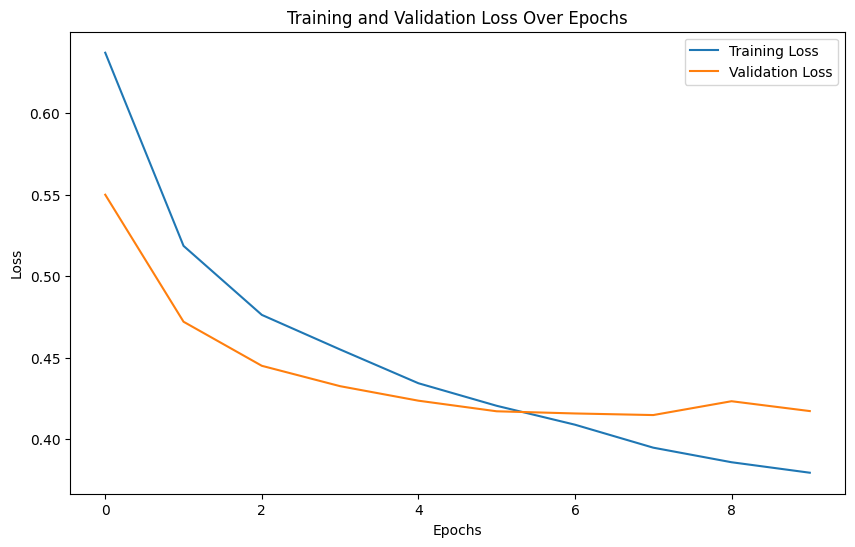

In [ ]:
# Get training history of the best model
best_history = best_result['history']

plt.figure(figsize=(10, 6))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


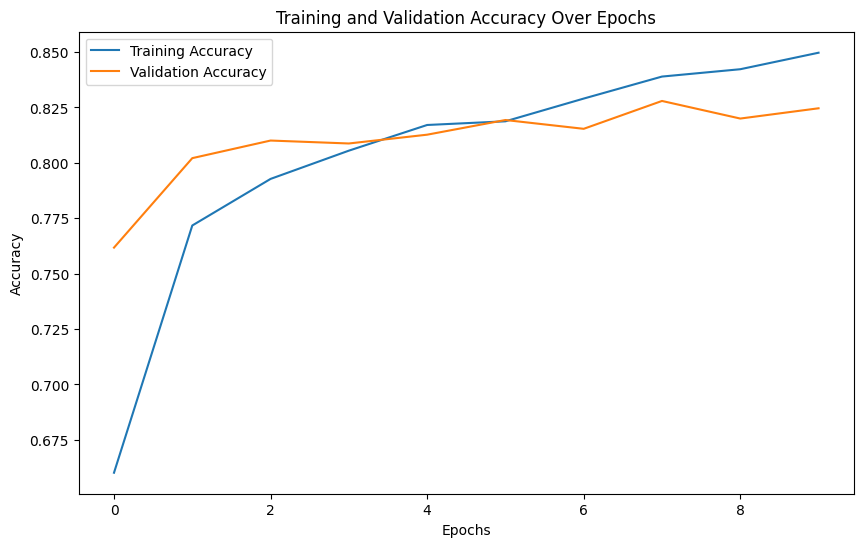

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(best_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


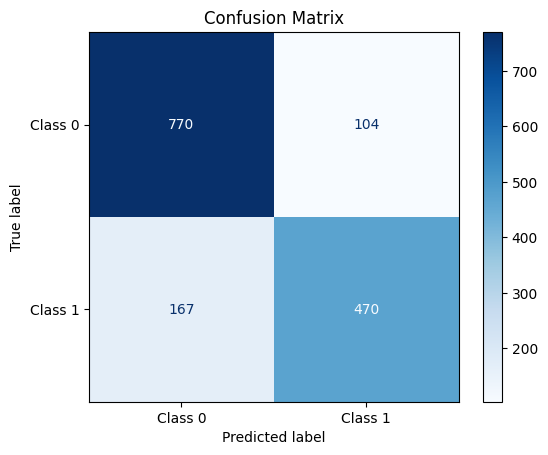

In [ ]:
# Predict on validation data
y_val_pred = (model.predict(X_val) > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

# Plot confusion matrix
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


- Hyperparameter Tuning via Random Search
    - LSTM Units:
        - [128]: Single-layer LSTM with 128 units.
        - [128, 64]: Two-layer LSTM with 128 units in the first layer and 64 in the second.
        - [64, 64, 32]: Three-layer LSTM with 64 units in the first layer, 64 units in the second layer and 32 in the final layer
    - Dropout_rate:
        - [0.2, 0.3, 0.4, 0.5]
        - Dropout rate applied after each LSTM layer to prevent overfitting by randomly deactivating neurons during training.
    - learning_rate:
        - [1e-3, 1e-4]
    - batch_size:
        - [32, 64]
        - Number of samples processed before the model updates its weights. Smaller batch size results in the capture of finer details while a larger batch size creates more stability.
    - epochs:
        - Went with 10 after experimenting. 
        
- The Best Hyperparameters were:
    - LSTM Units: 
        - [128, 64] - A two layer LSTM improved context capturing.
    - Dropout Rate: 
        - 0.2 - Lower dropout rates worked better in preventing overfitting while balancing learning rate
    - Learning Rate: 
        - 0.0001 - A smaller learning rate led to smoother convergence.
    - Batch Size: 
        - 64 - A medium batch size balanced memory usage and training speed.

- Validation Accuracy:
    - The best model achieved a validation accuracy of 82% which is pretty solid for random search 



# Conclusion 

Overall, I am happy with the way my LSTM model turned out with just using random search. I think if the scope of the project was bigger, 
I could definitely improve on my performance by using grid search with more parameters and more layers to the LSTM model.  
I think 80% on the testing set is not a bad result and puts me in the top 500 which is the top half for this rolling two month period. 
If I implemented a more aggressive hyperparameter tuning grid, I would also use early stopping to cut down on the model building time. 

In [ ]:
# Kaggle Submission 
# Preprocess the test data
test_sequences = tokenizer.texts_to_sequences(test['text'])
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Predict probabilities
test_predictions_prob = model.predict(test_padded, verbose=1)

# Convert probabilities to binary predictions
test_predictions = (test_predictions_prob > 0.5).astype(int).flatten()

# Prepare the submission 
submission = pd.DataFrame({
    'id': test['id'],
    'target': test_predictions
})

# Save submission 
submission_path = r"D:\\Disaster_Tweets\\submission.csv"
submission.to_csv(submission_path, index=False)
print(f"Submission file saved to: {submission_path}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Submission file saved to: D:\\Disaster_Tweets\\submission.csv
